In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
import plotly.express as px
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate, train_test_split as surprise_train_test_split, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from keras.optimizers import Adam

In [37]:
# Exploratory Data Analysis

In [3]:
# Load data
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

In [4]:
# Merge movies and ratings for a combined dataset
data = pd.merge(ratings, movies, on='movieId')

In [5]:
# Basic info about the dataset
print("Dataset Info:")
print(data.info())
print("\nFirst 5 rows:")
print(data.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
 4   title      100836 non-null  object 
 5   genres     100836 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 4.6+ MB
None

First 5 rows:
   userId  movieId  rating  timestamp                        title  \
0       1        1     4.0  964982703             Toy Story (1995)   
1       1        3     4.0  964981247      Grumpier Old Men (1995)   
2       1        6     4.0  964982224                  Heat (1995)   
3       1       47     5.0  964983815  Seven (a.k.a. Se7en) (1995)   
4       1       50     5.0  964982931   Usual Suspects, The (1995)   

                                        genre

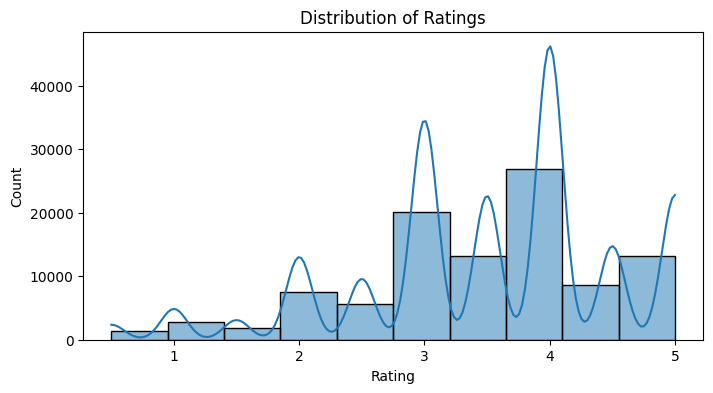

In [6]:
# 1. Distribution of ratings
plt.figure(figsize=(8,4))
sns.histplot(data['rating'], bins=10, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.tight_layout
plt.show()

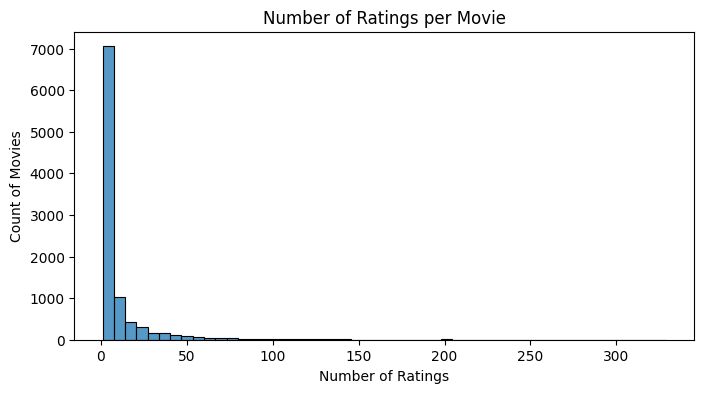

In [7]:
# 2. Number of ratings per movie
movie_ratings_count = data.groupby('movieId')['rating'].count().sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.histplot(movie_ratings_count, bins=50)
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Movies')
plt.tight_layout
plt.show()

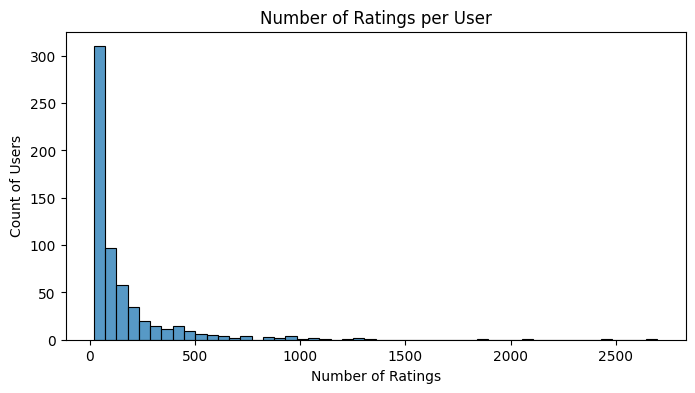

In [8]:
# 3. Number of ratings per user
user_ratings_count = data.groupby('userId')['rating'].count()
plt.figure(figsize=(8,4))
sns.histplot(user_ratings_count, bins=50)
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Users')
plt.tight_layout
plt.show()

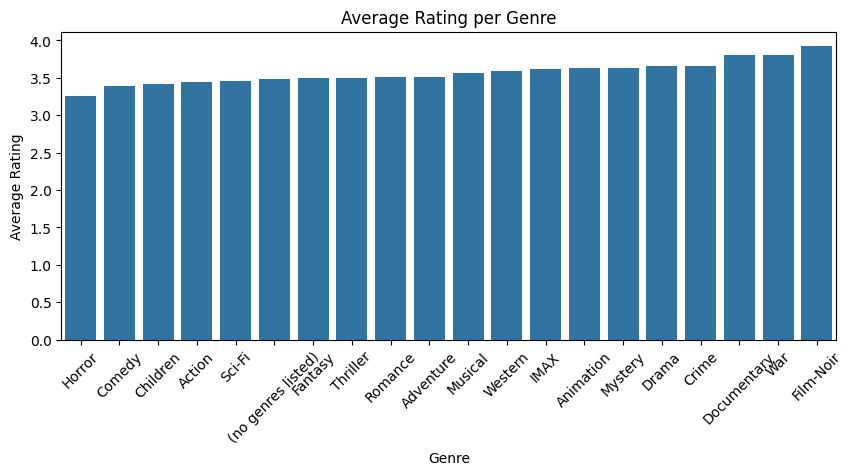

In [9]:
# 4. Average rating per genre (split genres into separate rows)
data_genres = data.assign(genres=data['genres'].str.split('|')).explode('genres')
genre_ratings = data_genres.groupby('genres')['rating'].mean().sort_values()
plt.figure(figsize=(10,4))
sns.barplot(x=genre_ratings.index, y=genre_ratings.values)
plt.title('Average Rating per Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.tight_layout
plt.show()

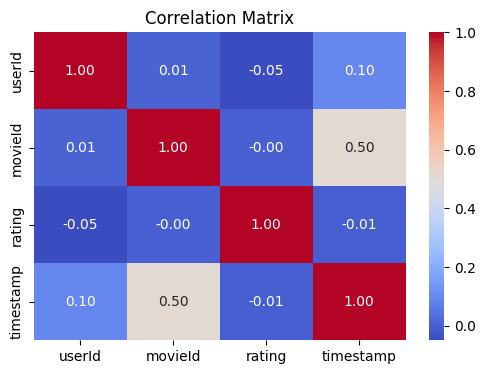

In [10]:
# 5. Correlation matrix (numeric features only)
numeric_data = data[['userId', 'movieId', 'rating', 'timestamp']]
plt.figure(figsize=(6,4))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout
plt.tight_layout
plt.show()

In [46]:
# Preprocessing

In [11]:
# Handle categorical features: Split genres into dummy variables
movies['genres'] = movies['genres'].str.split('|')
genres_encoded = movies['genres'].str.join('|').str.get_dummies('|')
movies_encoded = pd.concat([movies[['movieId', 'title']], genres_encoded], axis=1)

In [12]:
# Merge with ratings
data_encoded = pd.merge(ratings, movies_encoded, on='movieId')

In [13]:
# Drop unnecessary columns
data_encoded = data_encoded.drop(['timestamp'], axis=1)

In [14]:
# Check for missing values
print("Missing values:")
print(data_encoded.isnull().sum())

Missing values:
userId                0
movieId               0
rating                0
title                 0
(no genres listed)    0
Action                0
Adventure             0
Animation             0
Children              0
Comedy                0
Crime                 0
Documentary           0
Drama                 0
Fantasy               0
Film-Noir             0
Horror                0
IMAX                  0
Musical               0
Mystery               0
Romance               0
Sci-Fi                0
Thriller              0
War                   0
Western               0
dtype: int64


In [15]:
# Create user-movie matrix for collaborative filtering
user_movie_matrix = data_encoded.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)

In [16]:
# Scale the data (for potential use in clustering or regression)
scaler = StandardScaler()
user_movie_scaled = scaler.fit_transform(user_movie_matrix)

In [17]:
print("User-Movie Matrix Shape:", user_movie_matrix.shape)

User-Movie Matrix Shape: (610, 9724)


In [ ]:
# Singular Value Decomposition
# ----------------------------

In [18]:

# Prepare data for Surprise
reader = Reader(rating_scale=(0.5, 5.0))
data_surprise = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)


In [19]:

# Split data
trainset, testset = surprise_train_test_split(data_surprise, test_size=0.2)


In [21]:

# Train SVD model
svd = SVD(n_factors=50, random_state=42)
svd.fit(trainset)


In [22]:
# Evaluate model
predictions = svd.test(testset)
mse = mean_squared_error([pred.r_ui for pred in predictions], [pred.est for pred in predictions])
rmse = np.sqrt(mse)
print(f"SVD RMSE: {rmse}")

SVD RMSE: 0.8697190742743129


In [23]:
# Cross-validation
cross_val_results = cross_validate(svd, data_surprise, measures=['RMSE', 'MAE'], cv=5, verbose=True)
print("Cross-validation results:", cross_val_results)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8716  0.8605  0.8773  0.8775  0.8679  0.8709  0.0064  
MAE (testset)     0.6681  0.6642  0.6704  0.6732  0.6697  0.6691  0.0030  
Fit time          2.11    2.96    1.82    1.47    1.51    1.97    0.54    
Test time         0.40    0.36    0.30    0.26    0.26    0.32    0.05    
Cross-validation results: {'test_rmse': array([0.87160158, 0.86046662, 0.8772661 , 0.87746737, 0.86790163]), 'test_mae': array([0.668107  , 0.66418184, 0.67036764, 0.6732303 , 0.6696595 ]), 'fit_time': (2.1108973026275635, 2.9565694332122803, 1.8157005310058594, 1.4729843139648438, 1.5124835968017578), 'test_time': (0.3950672149658203, 0.3617122173309326, 0.29735517501831055, 0.2562215328216553, 0.26483821868896484)}


In [ ]:
# K-Means Clustering
# ------------------

In [24]:
# Apply K-Means on user-movie matrix
kmeans = KMeans(n_clusters=5, random_state=42)
user_clusters = kmeans.fit_predict(user_movie_scaled)

In [25]:
# Add cluster labels to user data
user_movie_matrix['cluster'] = user_clusters

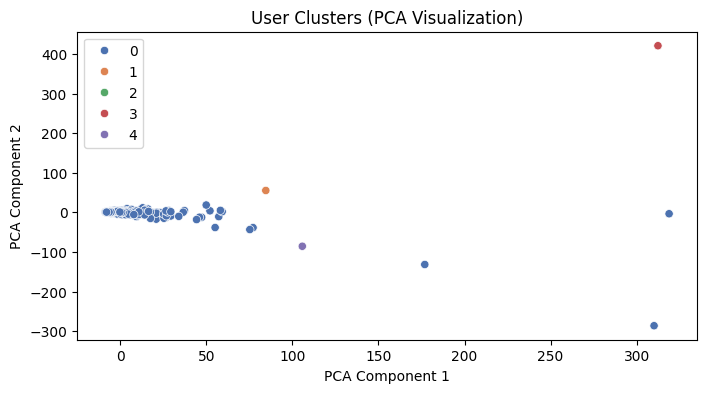

In [26]:
# Visualize clusters with PCA
pca = PCA(n_components=2)
user_movie_pca = pca.fit_transform(user_movie_scaled)
plt.figure(figsize=(8,4))
sns.scatterplot(x=user_movie_pca[:, 0], y=user_movie_pca[:, 1], hue=user_clusters, palette='deep')
plt.title('User Clusters (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.tight_layout
plt.show()

In [ ]:
# Linear regression
# -----------------

In [27]:
# Prepare data for regression
X = data_encoded.drop(['rating', 'title'], axis=1)
y = data_encoded['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# Train Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [29]:
# Predict and evaluate
y_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse)
print(f"Linear Regression RMSE: {rmse_lr}")

Linear Regression RMSE: 1.0249230680141252


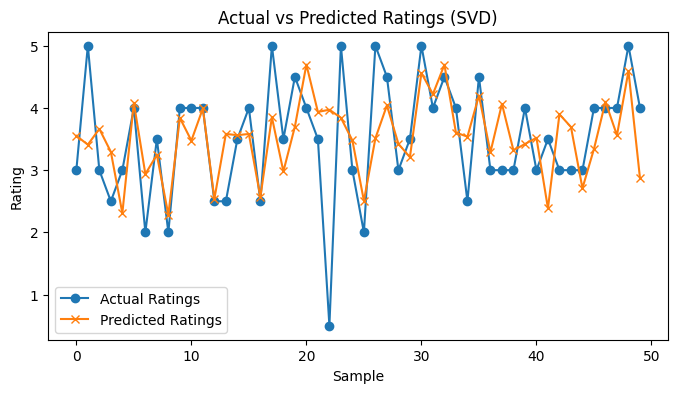

In [30]:
# Compare actual vs predicted ratings for SVD
actual_ratings = [pred.r_ui for pred in predictions[:50]]
predicted_ratings = [pred.est for pred in predictions[:50]]
plt.figure(figsize=(8,4))
plt.plot(actual_ratings, label='Actual Ratings', marker='o')
plt.plot(predicted_ratings, label='Predicted Ratings', marker='x')
plt.title('Actual vs Predicted Ratings (SVD)')
plt.xlabel('Sample')
plt.ylabel('Rating')
plt.legend()
plt.tight_layout
plt.show()

In [ ]:
# Recommendations for the user

In [31]:
# Function to get top-N recommendations for a user
def get_top_n_recommendations(user_id, n=5):
    # Get all movie IDs
    all_movie_ids = movies['movieId'].unique()
    # Get movies already rated by the user
    rated_movies = ratings[ratings['userId'] == user_id]['movieId'].values
    # Predict ratings for unrated movies
    unrated_movies = [mid for mid in all_movie_ids if mid not in rated_movies]
    predictions = [svd.predict(user_id, mid) for mid in unrated_movies]
    # Sort by predicted rating
    top_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
    # Get movie titles
    top_movie_ids = [pred.iid for pred in top_predictions]
    top_titles = movies[movies['movieId'].isin(top_movie_ids)]['title'].values
    return top_titles

# Example: Recommendations for user 1
print("Top 5 recommendations for User 1:")
print(get_top_n_recommendations(1))

Top 5 recommendations for User 1:
['Shawshank Redemption, The (1994)' 'Casablanca (1942)'
 'Seven Samurai (Shichinin no samurai) (1954)'
 'Boondock Saints, The (2000)' 'Thank You for Smoking (2006)']


In [ ]:
# Hyperparameter optimisation for SVD
# -----------------------------------

In [32]:
# Load data
ratings = pd.read_csv('ratings.csv')
reader = Reader(rating_scale=(0.5, 5.0))
data_surprise = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [33]:
# Define parameter grid for SVD
param_grid = {
    'n_factors': [50, 100, 150],  # Number of latent factors
    'n_epochs': [20, 30],         # Number of iterations
    'lr_all': [0.002, 0.005],     # Learning rate
    'reg_all': [0.02, 0.1]        # Regularization term
}

In [34]:
# Perform Grid Search with cross-validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
gs.fit(data_surprise)

In [35]:
# Best parameters and score
print("Best RMSE:", gs.best_score['rmse'])
print("Best parameters:", gs.best_params['rmse'])

Best RMSE: 0.8655552603950184
Best parameters: {'n_factors': 150, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1}


In [37]:
# Train the best model
best_svd = SVD(**gs.best_params['rmse'], random_state=42)
trainset, testset = surprise_train_test_split(data_surprise, test_size=0.2)
best_svd.fit(trainset)

In [38]:
# Evaluate on test set
predictions = best_svd.test(testset)
mse = mean_squared_error([pred.r_ui for pred in predictions], [pred.est for pred in predictions])
rmse = sqrt(mse)
print(f"Optimized SVD RMSE: {rmse}")

Optimized SVD RMSE: 0.8685923829850177


In [ ]:
# Neural Collaborative Filtering for recommendations
# --------------------------------------------------

In [39]:
# Load and prepare data
ratings = pd.read_csv('ratings.csv')

In [40]:
# Encode userId and movieId to continuous integers
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()
ratings['userId'] = user_encoder.fit_transform(ratings['userId'])
ratings['movieId'] = movie_encoder.fit_transform(ratings['movieId'])

In [41]:
# Split data into train and test sets
X = ratings[['userId', 'movieId']].values
y = ratings['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
# Get number of unique users and movies
n_users = ratings['userId'].nunique()
n_movies = ratings['movieId'].nunique()

In [ ]:
# Model building and training

In [43]:
# Define model parameters
embedding_size = 50  # Size of embedding vectors

In [44]:
# Input layers
user_input = Input(shape=(1,), name='user_input')
movie_input = Input(shape=(1,), name='movie_input')

In [46]:
# Embedding layers
user_embedding = Embedding(n_users, embedding_size, name='user_embedding')(user_input)
movie_embedding = Embedding(n_movies, embedding_size, name='movie_embedding')(movie_input)

In [47]:
# Flatten embeddings
user_vec = Flatten(name='flatten_users')(user_embedding)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

In [48]:
# Concatenate user and movie vectors
concat = Concatenate(name='concatenate')([user_vec, movie_vec])

In [49]:
# Dense layers
dense_1 = Dense(128, activation='relu', name='dense_1')(concat)
dropout_1 = Dropout(0.2, name='dropout_1')(dense_1)
dense_2 = Dense(64, activation='relu', name='dense_2')(dropout_1)
dropout_2 = Dropout(0.2, name='dropout_2')(dense_2)
output = Dense(1, activation='linear', name='output')(dropout_2)

In [50]:
# Define and compile model
model = Model(inputs=[user_input, movie_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

In [51]:
# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 50)     │     30,500 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding     │ (None, 1, 50)     │    486,200 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_users       │ (None, 50)        │          0 │ user_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_movies      │ (None, 50)        │          0 │ movie_embedding[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 100)       │          0 │ flatten_users[0]… │
│ (Concatenate)       │                   │            │ flatten_movies[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     12,928 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 537,949 (2.05 MB)

 Trainable params: 537,949 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Train the model
history = model.fit(
    [X_train[:, 0], X_train[:, 1]], y_train,
    validation_data=([X_test[:, 0], X_test[:, 1]], y_test),
    epochs=20,
    batch_size=64,
    verbose=1
)

Epoch 1/20
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 36s 26ms/step - loss: 2.5309 - mae: 1.1663 - val_loss: 0.8064 - val_mae: 0.6936
Epoch 2/20
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - loss: 0.8738 - mae: 0.7311 - val_loss: 0.7765 - val_mae: 0.6809
Epoch 3/20
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - loss: 0.8028 - mae: 0.6977 - val_loss: 0.7740 - val_mae: 0.6826
Epoch 4/20
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - loss: 0.7397 - mae: 0.6673 - val_loss: 0.7674 - val_mae: 0.6744
Epoch 5/20
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - loss: 0.6949 - mae: 0.6440 - val_loss: 0.7626 - val_mae: 0.6694
Epoch 6/20
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - loss: 0.6470 - mae: 0.6201 - val_loss: 0.7646 - val_mae: 0.6725
Epoch 7/20
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - loss: 0.6020 - mae: 0.5953 - val_loss: 0.7741 - val_mae: 0.6734
Epoch 8/20
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - loss: 0.5574 - mae: 0.5704 - val_loss: 0.7845 - val_mae: 0.6808
Epoch 9/20
1261/1261 ━━━

In [53]:

# Evaluate the model
y_pred = model.predict([X_test[:, 0], X_test[:, 1]])
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Neural Network RMSE: {rmse_nn}")

631/631 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Neural Network RMSE: 0.9451230787029881


In [ ]:
# Visualisation of learning

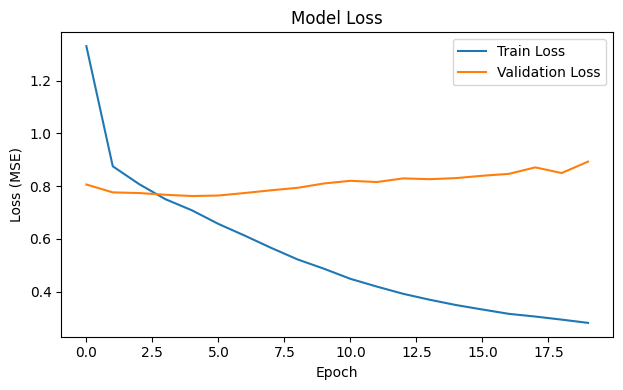

In [54]:
# Plot training history
plt.figure(figsize=(12,4))
# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.tight_layout()
plt.show()

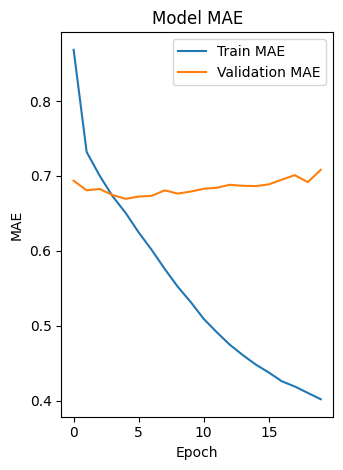

In [55]:
# MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Recommendations with neural network

In [56]:
# Function to get top-N recommendations using neural network
def get_nn_recommendations(user_id, n=5):
    user_id_encoded = user_encoder.transform([user_id])[0]
    all_movie_ids = np.arange(n_movies)
    user_array = np.array([user_id_encoded] * n_movies)
    movie_array = all_movie_ids
    pred_ratings = model.predict([user_array, movie_array], verbose=0).flatten()
    top_indices = pred_ratings.argsort()[-n:][::-1]
    top_movie_ids = movie_encoder.inverse_transform(top_indices)
    top_titles = movies[movies['movieId'].isin(top_movie_ids)]['title'].values
    return top_titles

# Example: Recommendations for user 1
print("Top 5 NN recommendations for User 1:")
print(get_nn_recommendations(1))

Top 5 NN recommendations for User 1:
['Phantom of the Paradise (1974)' 'Woman Under the Influence, A (1974)'
 'Frozen River (2008)' 'Imposter, The (2012)' 'Cosmos']


In [ ]:
# Method of Random Forest
# -----------------------

In [57]:
# Load data
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

In [58]:
# Merge ratings and movies
data = pd.merge(ratings, movies, on='movieId')

In [59]:
# Handle categorical features: Split genres into dummy variables
data['genres'] = data['genres'].str.split('|')
genres_encoded = data['genres'].str.join('|').str.get_dummies('|')
data_encoded = pd.concat([data[['userId', 'movieId', 'rating']], genres_encoded], axis=1)

In [60]:
# Drop timestamp and title as they are not needed
data_encoded = data_encoded.drop(['timestamp'], axis=1, errors='ignore')

In [61]:
# Prepare features (X) and target (y)
X = data_encoded.drop('rating', axis=1)
y = data_encoded['rating']

In [62]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (80668, 22)
Test set shape: (20168, 22)


In [ ]:
# Random Forest Training

In [63]:
# Train Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=42)

In [64]:
# Predict on test set
y_pred_rf = rf.predict(X_test)

In [65]:
# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)  # Calculate MSE
rmse_rf = np.sqrt(mse_rf)  # Take the square root to get RMSE
print(f"Random Forest RMSE: {rmse_rf}")

Random Forest RMSE: 0.961500411595055


In [ ]:
# Analysing the importance of features

In [66]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

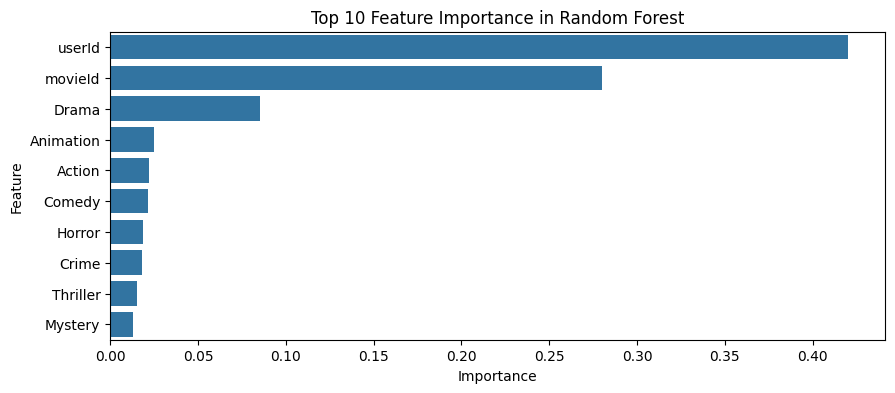

In [67]:
# Plot feature importance
plt.figure(figsize=(10,4))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importance in Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
# Visualisation of predictions

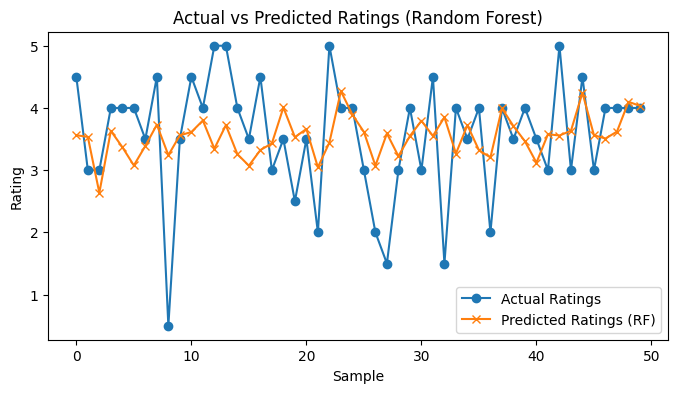

In [68]:
# Compare actual vs predicted ratings
plt.figure(figsize=(8,4))
plt.plot(y_test.values[:50], label='Actual Ratings', marker='o')
plt.plot(y_pred_rf[:50], label='Predicted Ratings (RF)', marker='x')
plt.title('Actual vs Predicted Ratings (Random Forest)')
plt.xlabel('Sample')
plt.ylabel('Rating')
plt.legend()
plt.tight_layout
plt.show()

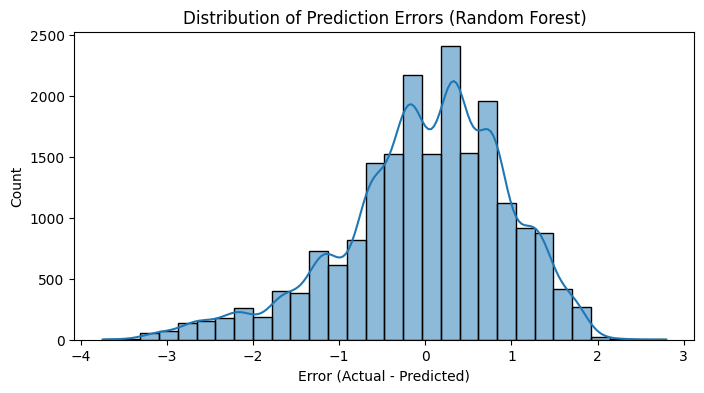

In [69]:
# Distribution of prediction errors
errors = y_test - y_pred_rf
plt.figure(figsize=(8,4))
sns.histplot(errors, bins=30, kde=True)
plt.title('Distribution of Prediction Errors (Random Forest)')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Count')
plt.tight_layout
plt.show()

In [ ]:
# Recommendations with Random Forest

In [73]:
# Function to get top-N recommendations using Random Forest
def get_rf_recommendations(user_id, n=5):
    # Get all movie IDs
    all_movie_ids = movies['movieId'].unique()
    # Get movies already rated by the user
    rated_movies = ratings[ratings['userId'] == user_id]['movieId'].values
    # Prepare data for unrated movies
    unrated_movies = [mid for mid in all_movie_ids if mid not in rated_movies]
    user_data = pd.DataFrame({
        'userId': [user_id] * len(unrated_movies),
        'movieId': unrated_movies
    })
    # Add genre features
    user_data = pd.merge(user_data, movies[['movieId', 'genres']], on='movieId')
    user_data['genres'] = user_data['genres'].str.split('|')
    genres_encoded = user_data['genres'].str.join('|').str.get_dummies('|')
    user_data_encoded = pd.concat([user_data[['userId', 'movieId']], genres_encoded], axis=1)
    # Ensure columns match training data
    missing_cols = set(X_train.columns) - set(user_data_encoded.columns)
    for col in missing_cols:
        user_data_encoded[col] = 0
    user_data_encoded = user_data_encoded[X_train.columns]
    # Predict ratings
    pred_ratings = rf.predict(user_data_encoded)
    # Convert unrated_movies to NumPy array for proper indexing
    unrated_movies_array = np.array(unrated_movies)
    # Get top-N movies
    top_indices = np.argsort(pred_ratings)[::-1][:n]
    top_movie_ids = unrated_movies_array[top_indices]
    top_titles = movies[movies['movieId'].isin(top_movie_ids)]['title'].values
    return top_titles

# Example: Recommendations for user 1
print("Top 5 RF recommendations for User 1:")
print(get_rf_recommendations(1))

Top 5 RF recommendations for User 1:
['Savior (1998)' 'Glen or Glenda (1953)' 'Stepmom (1998)'
 'Hilary and Jackie (1998)' 'At First Sight (1999)']
